In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

global_t = 0.0096
k_lab = [D//10, D//6, D//3, D//2, D]
trial_num = 5

In [6]:
train_data, test_data = generate_synthetic_data_with_noise(N, z_size, D)
train_data.to(device)
test_data.to(device)

tensor([[0.0000, 0.1907, 0.0000,  ..., 0.5329, 0.6371, 0.4690],
        [0.0000, 0.0000, 0.0000,  ..., 0.3878, 0.3787, 0.6062],
        [0.1067, 0.0000, 0.0000,  ..., 0.4175, 0.3398, 0.6803],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4536, 0.8283, 0.6763],
        [0.0000, 0.2083, 0.0000,  ..., 0.6805, 0.5686, 0.5650],
        [0.0000, 0.0000, 0.0000,  ..., 0.1979, 0.5258, 0.3618]],
       device='cuda:0')

In [7]:
BASE_PATH = "../data/models/final_run/"
# BASE_PATH = '/scratch/ns3429/sparse-subset/data/models/final_run/'

In [8]:
def load_trial_model(trial_path, k):
    if ('vanilla_vae_gumbel' in trial_path):
        model = VAE_Gumbel(2*D, 100, 20, k = k, t = global_t) 
    if ('batching_gumbel_vae' in trial_path):
        model = VAE_Gumbel_NInsta(2*D, 100, 20, k = k, t = global_t)
    if ('globalgate_vae' in trial_path):
        model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = k, t = global_t)
    if ('runningstate_vae' in trial_path):
        model = VAE_Gumbel_RunningState(2*D, 100, 20, k = k, t = global_t, alpha = 0.9)
    if ('concrete_vae_nmsl' in trial_path):
        model = ConcreteVAE_NMSL(2*D, 100, 20, k = k, t = global_t)
    
    model.load_state_dict(torch.load(trial_path))
    model.to(device)
    model.eval()
    
    return model

In [9]:
def obtain_model_metrics(model):
    pass

In [10]:
# test model
path = '../data/models/final_run/vanilla_vae_gumbel/k_15/model_trial_3.pt'
model = VAE_Gumbel(2*D, 100, 20, k = 15, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)

VAE_Gumbel(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): Sigmoid()
  )
  (weight_creator): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

BCE

In [11]:
test_df = test_data[0:64, :]
with torch.no_grad():
    pred_df = model(test_df)[0]

In [12]:
test_df.mean(dim = 0)

tensor([0.0464, 0.1195, 0.0845, 0.0104, 0.2252, 0.1259, 0.1879, 0.2976, 0.1553,
        0.1303, 0.3214, 0.1200, 0.0780, 0.2892, 0.1563, 0.0764, 0.1087, 0.0170,
        0.3132, 0.1194, 0.0414, 0.1190, 0.1890, 0.1809, 0.1659, 0.1510, 0.1903,
        0.1344, 0.0871, 0.0294, 0.4809, 0.4847, 0.4540, 0.4661, 0.4507, 0.5386,
        0.5251, 0.4553, 0.4645, 0.5043, 0.5350, 0.4467, 0.4940, 0.4733, 0.5062,
        0.4916, 0.4410, 0.4825, 0.4733, 0.4785, 0.5255, 0.4801, 0.5315, 0.5335,
        0.5443, 0.4986, 0.5396, 0.4663, 0.4663, 0.4903], device='cuda:0')

In [13]:
pred_df.mean(dim=0)

tensor([0.0597, 0.1226, 0.0933, 0.0215, 0.2053, 0.1183, 0.1893, 0.3040, 0.1669,
        0.1424, 0.3139, 0.1237, 0.0896, 0.2730, 0.1713, 0.0849, 0.1042, 0.0147,
        0.3174, 0.1056, 0.0482, 0.1075, 0.1956, 0.1717, 0.1571, 0.1396, 0.1914,
        0.1399, 0.0898, 0.0288, 0.4693, 0.5045, 0.4498, 0.4650, 0.4320, 0.5507,
        0.5151, 0.4588, 0.4848, 0.5051, 0.5325, 0.4693, 0.5141, 0.4666, 0.5050,
        0.5037, 0.4518, 0.5022, 0.4758, 0.4790, 0.5430, 0.4874, 0.5152, 0.5137,
        0.5315, 0.5029, 0.5219, 0.4826, 0.4931, 0.5091], device='cuda:0')

In [14]:
F.binary_cross_entropy(pred_df, test_df, reduction = 'sum')

tensor(1867.6130, device='cuda:0')

In [15]:
def bce_model(data, model):
    test_loss = 0
    inds = np.arange(data.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(data)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]

            test_pred = model(batch_data)[0]


            test_loss += F.binary_cross_entropy(test_pred, batch_data, reduction='sum')

            del batch_data
    return test_loss / data.shape[0]

In [16]:
bce_model(test_data, model)

tensor(29.2328, device='cuda:0')

In [17]:
def top_logits_gumbel_vanilla_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_subsets = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    all_subsets = all_subsets.to(device)
    inds = np.arange(data.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(data)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]
            
            logits = model.weight_creator(batch_data)
            
            
            topk_logits = torch.topk(logits, k = model.k, dim = 1, sorted = True)[1]
            one_hotted_top_k = torch.nn.functional.one_hot(topk_logits, num_classes = data.shape[1]).sum(dim = 1)
            
            #subsets = sample_subset(logits, model.k, model.t, separate = True)
            subsets = sample_subset(logits, model.k, model.t)
            #max_idx = torch.argmax(subsets, 2, keepdim=True)
            #one_hot = Tensor(subsets.shape)
            #one_hot.zero_()
            #one_hot.scatter_(2, max_idx, 1)
    
    
            all_logits += one_hotted_top_k.sum(dim = 0)
            #all_subsets += one_hot.sum(dim = (0, 1))
            all_subsets += subsets.sum(dim = 0)
            
            
    
        all_logits /= data.shape[0]
        all_subsets /= data.shape[0]
    
    return all_logits, all_subsets

In [18]:
def top_logits_gumbel_batching_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel_NInsta)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_subsets = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    all_subsets = all_subsets.to(device)
    inds = np.arange(data.shape[0])
    num_batches = math.ceil(len(data)/batch_size)
    with torch.no_grad():
        for i in range(num_batches):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]

            w0 = model.weight_creator(batch_data)
            w = w0.mean(dim = 0)
            top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
            enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)

            #subsets = sample_subset(w, model.k,model.t,True)
            subsets = sample_subset(w, model.k,model.t)
            #max_idx = torch.argmax(subsets, 1, keepdim=True)
            #one_hot = Tensor(subsets.shape)
            #one_hot.zero_()
            #one_hot.scatter_(1, max_idx, 1)
            
            all_logits += enc_top_logits
            all_subsets += subsets
    
        all_logits /= num_batches
        all_subsets /= num_batches
    
    return all_logits, all_subsets

In [19]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

In [20]:
def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = 2*D).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

In [21]:
def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)

        inds = torch.argsort(subset_indices.sum(dim = 0), descending = True)[:model.k]
        all_logits = torch.nn.functional.one_hot(inds, num_classes = 2 * D).sum(dim = 0)
        
        
        
        
    return all_logits, all_subsets

In [22]:
# test model
path = '../data/models/final_run/vanilla_vae_gumbel/k_30/model_trial_3.pt'
model = VAE_Gumbel(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()
top_logits_gumbel_vanilla_vae_gumbel(test_data, model)

(tensor([0.6715, 0.2900, 1.0000, 0.3995, 0.7725, 0.7840, 0.4315, 0.3925, 0.7065,
         0.8240, 0.9245, 0.6465, 0.9950, 0.6045, 0.9605, 0.8130, 0.7585, 0.4145,
         0.6825, 0.9945, 0.9810, 0.9775, 1.0000, 0.9575, 0.3060, 0.9935, 0.7850,
         0.9725, 0.9520, 0.6210, 0.8380, 0.1650, 0.0760, 0.6770, 0.2245, 0.0000,
         0.0630, 0.4400, 0.0000, 0.2070, 0.0345, 0.0200, 0.0000, 0.6330, 0.1620,
         0.3225, 0.8050, 0.0600, 0.0000, 0.0000, 0.0550, 0.0055, 0.4010, 0.0000,
         0.2355, 0.0105, 0.4260, 0.4510, 0.0785, 0.9975], device='cuda:0'),
 tensor([6.0916e-01, 2.5105e-01, 1.1129e+00, 3.3933e-01, 7.8717e-01, 7.1790e-01,
         4.1985e-01, 3.8166e-01, 7.2880e-01, 8.4613e-01, 9.6075e-01, 6.2987e-01,
         1.0458e+00, 5.8740e-01, 1.0205e+00, 8.0180e-01, 7.5351e-01, 4.2166e-01,
         6.7492e-01, 1.0915e+00, 1.0252e+00, 9.8995e-01, 1.0376e+00, 1.0211e+00,
         2.7132e-01, 9.8867e-01, 8.0917e-01, 9.7767e-01, 9.7388e-01, 5.5889e-01,
         8.1808e-01, 1.4444e-01, 

In [23]:
# test model
path = '../data/models/final_run/batching_gumbel_vae/k_30/model_trial_3.pt'
model = VAE_Gumbel_NInsta(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()
top_logits_gumbel_batching_vae_gumbel(test_data, model)[1].sum()

tensor(30., device='cuda:0')

In [24]:
path = '../data/models/final_run/globalgate_vae/k_30/model_trial_1.pt'
model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()
top_logits_gumbel_globalgate_vae(test_data, model)[0].sum()

tensor(30, device='cuda:0')

In [25]:
path = '../data/models/final_run/runningstate_vae/k_30/model_trial_1.pt'
model = VAE_Gumbel_RunningState(2*D, 100, 20, k = 30, t = global_t, alpha = 0.9) 
model.logit_enc = nn.Parameter(torch.zeros(2*D).view(1, -1))
model.to(device)
model.load_state_dict(torch.load(path))
model.eval()

top_logits_gumbel_runningstate_vae(test_data, model)[0].sum()

tensor(30, device='cuda:0')

In [26]:
path = '../data/models/final_run/concrete_vae_nmsl/k_30/model_trial_1.pt'
model = ConcreteVAE_NMSL(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()
top_logits_gumbel_concrete_vae_nsml(test_data, model)[0].sum()

tensor(30, device='cuda:0')

In [27]:
model(test_df)
top_ind = torch.argmax(model.logit_enc, dim = 1)
sum(top_ind < 30)

tensor(29, device='cuda:0')

In [28]:
top_ind

tensor([10,  8,  9, 40, 11,  4,  7, 10, 27,  2, 24, 24, 27, 13,  2, 23, 18, 23,
        25, 22, 14,  6,  4,  9, 21, 18,  4, 27, 11, 18], device='cuda:0')

Look at BCE per Method

Looking at Vanilla VAE

In [29]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/vanilla_vae_gumbel/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval()
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())
    
print("Vanilla Gumbel VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

Vanilla Gumbel VAE
Train BCES
[29.9329833984375, 29.5721435546875, 29.27056312561035, 29.193561553955078, 28.98382568359375]
Test BCES
[29.977725982666016, 29.630605697631836, 29.314844131469727, 29.234220504760742, 29.037967681884766]


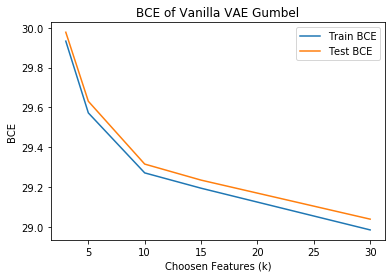

In [30]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Vanilla VAE Gumbel")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Batching Gumbel

In [31]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/batching_gumbel_vae/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel_NInsta(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval()
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())

print("Batching Gumbel VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

Batching Gumbel VAE
Train BCES
[30.6058292388916, 29.871030807495117, 29.441598892211914, 29.2967472076416, 29.133390426635742]
Test BCES
[30.660202026367188, 29.942962646484375, 29.502365112304688, 29.335660934448242, 29.17584800720215]


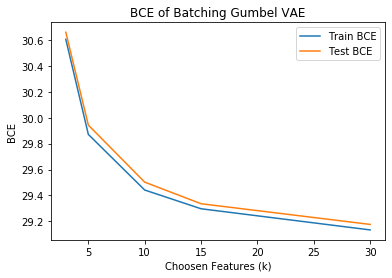

In [32]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Batching Gumbel VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Global Gate VAE

In [33]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/globalgate_vae/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = VAE_Gumbel_GlobalGate(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval()
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())

print("Global Gate VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

Global Gate VAE
Train BCES
[31.41971206665039, 31.017847061157227, 30.2842960357666, 29.786075592041016, 29.37660789489746]
Test BCES
[31.471643447875977, 31.035184860229492, 30.354108810424805, 29.857641220092773, 29.42584800720215]


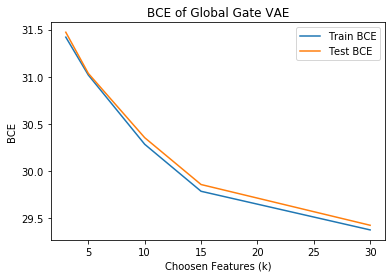

In [34]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Global Gate VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

RunningState VAE

In [35]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    # test model
    path = '../data/models/final_run/runningstate_vae/k_{}/model_trial_{}.pt'.format(k, 1)
    model = VAE_Gumbel_RunningState(2*D, 100, 20, k = k, t = global_t, alpha = 0.9) 
    model.logit_enc = nn.Parameter(torch.zeros(2*D).view(1, -1))
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    train_bce = bce_model(train_data, model)
    test_bce = bce_model(test_data, model)
    train_bces.append((train_bce).item())
    test_bces.append((test_bce).item())
    
print("RunningState VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

RunningState VAE
Train BCES
[30.79286003112793, 29.8808536529541, 29.420034408569336, 29.287586212158203, 29.13748550415039]
Test BCES
[30.82596778869629, 29.924489974975586, 29.476173400878906, 29.326866149902344, 29.184446334838867]


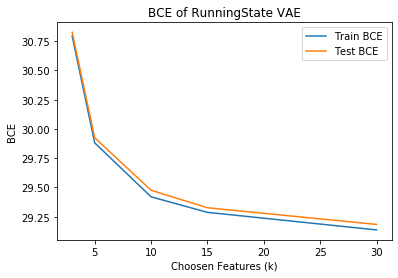

In [36]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of RunningState VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

Concrete VAE

In [37]:
train_bces = []
test_bces = []
for k in k_lab:
    train_bce = 0
    test_bce = 0
    for trial in range(1, 1+trial_num):
        # test model
        path = '../data/models/final_run/concrete_vae_nmsl/k_{}/model_trial_{}.pt'.format(k, trial_num)
        model = ConcreteVAE_NMSL(2*D, 100, 20, k = k, t = global_t) 
        model.load_state_dict(torch.load(path))
        model.to(device)
        train_bce += bce_model(train_data, model)
        test_bce += bce_model(test_data, model)
    train_bces.append((train_bce/trial_num).item())
    test_bces.append((test_bce/trial_num).item())
    
print("Concrete VAE")
print("Train BCES")
print(train_bces)
print("Test BCES")
print(test_bces)

Concrete VAE
Train BCES
[31.291473388671875, 30.965808868408203, 30.55527114868164, 30.193090438842773, 29.898605346679688]
Test BCES
[31.33077049255371, 31.01283836364746, 30.614179611206055, 30.20159912109375, 29.921903610229492]


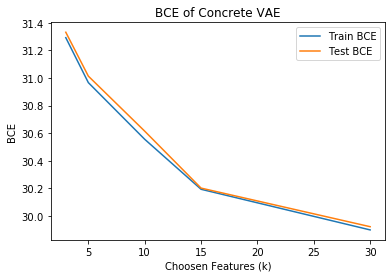

In [38]:
fig = plt.figure()
plt.plot(k_lab, train_bces, label = 'Train BCE')
plt.plot(k_lab, test_bces, label = 'Test BCE')

plt.title("BCE of Concrete VAE")
plt.xlabel("Choosen Features (k)")
plt.ylabel("BCE")
plt.legend()

**Look at Top Logits and Top Subsets of Each Method**

In [39]:
from functools import partial

In [40]:
def load_model(path, model_constructor):
    model = model_constructor()
    if 'runningstate_vae' in path:
        model.logit_enc = nn.Parameter(torch.zeros(2*D).view(1, -1))
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    
    return model

In [41]:
def visualize_top_logits_generic(data, model_type, model_constructor, logits_getter, trial_num = 5):
    print("TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE")
    generic_path = '../data/models/final_run/{}/k_{}/model_trial_{}.pt'
    inds = np.arange(data.shape[0])
    
    fig, axes = plt.subplots(nrows = 2, ncols = len(k_lab), figsize = (15, 10))
    labels = ['logits', 'subsets']
    y_labels = ['Frequency', 'Activation']
    titles = ['Top Logits', 'Feature Strength']
    graph_logits = []
    graph_subsets = []
    
    
    for k in k_lab:
        all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
        all_subsets = torch.zeros(data.shape[1], dtype = torch.float32)
        all_logits = all_logits.to(device)
        all_subsets = all_subsets.to(device)
        for trial in range(1, 1+trial_num):
            # test model
            path = generic_path.format(model_type, k, trial_num)
            model_constr = partial(model_constructor, 2*D, 100, 20, k = k, t = global_t)
            model = load_model(path, model_constr)
            
            logits, gumbels = logits_getter(test_data, model)
            
            all_logits += logits
            all_subsets += gumbels
            
        all_logits /= trial_num
        all_subsets /= trial_num
        graph_logits.append(all_logits)
        graph_subsets.append(all_subsets)
    feature_ind = np.arange(2*D)
    for i in range(len(k_lab)):
        ax0 = axes[0, i]
        ax1 = axes[1, i]
        ax0.bar(feature_ind, graph_logits[i].cpu().numpy())
        ax1.bar(feature_ind, graph_subsets[i].cpu().numpy())
        ax1.set_xlabel("Chosen Number of Features")
        ax0.set_title("Top Logits, k = {}".format(k_lab[i]))
        ax1.set_title("Feature Strength, k = {}".format(k_lab[i]))
        
    axes[0, 0].set_ylabel("Frequency")
    axes[1, 0].set_ylabel("Actiation")
    plt.tight_layout()
        
        


TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE


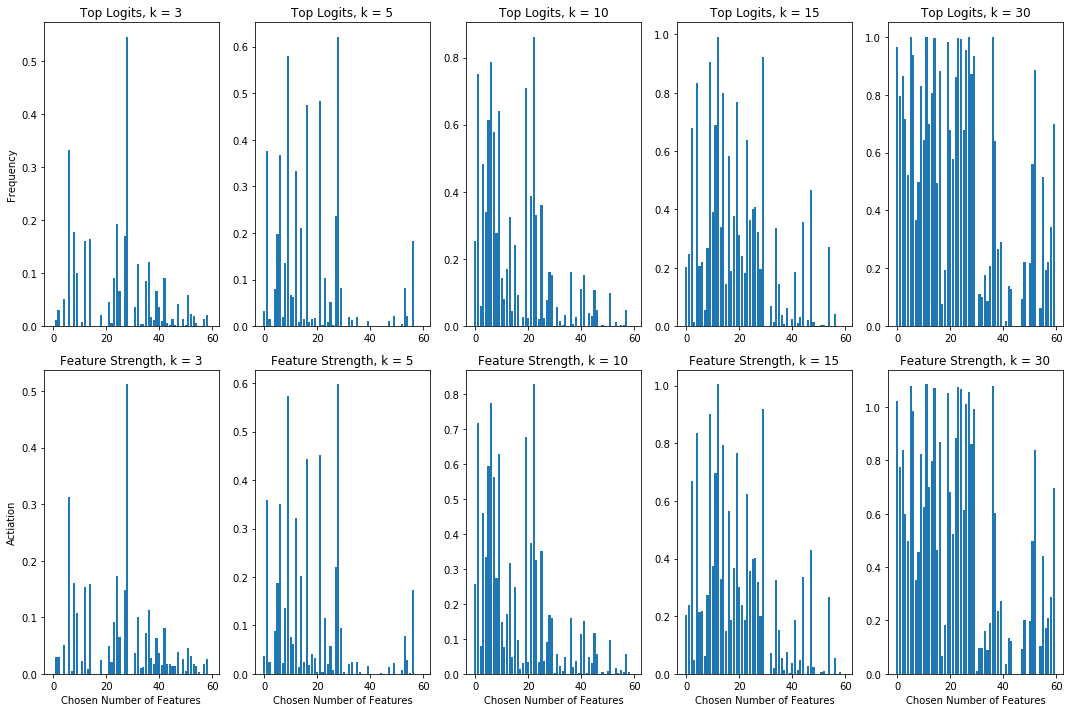

In [42]:
visualize_top_logits_generic(test_data, 'vanilla_vae_gumbel', VAE_Gumbel, top_logits_gumbel_vanilla_vae_gumbel)

TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE


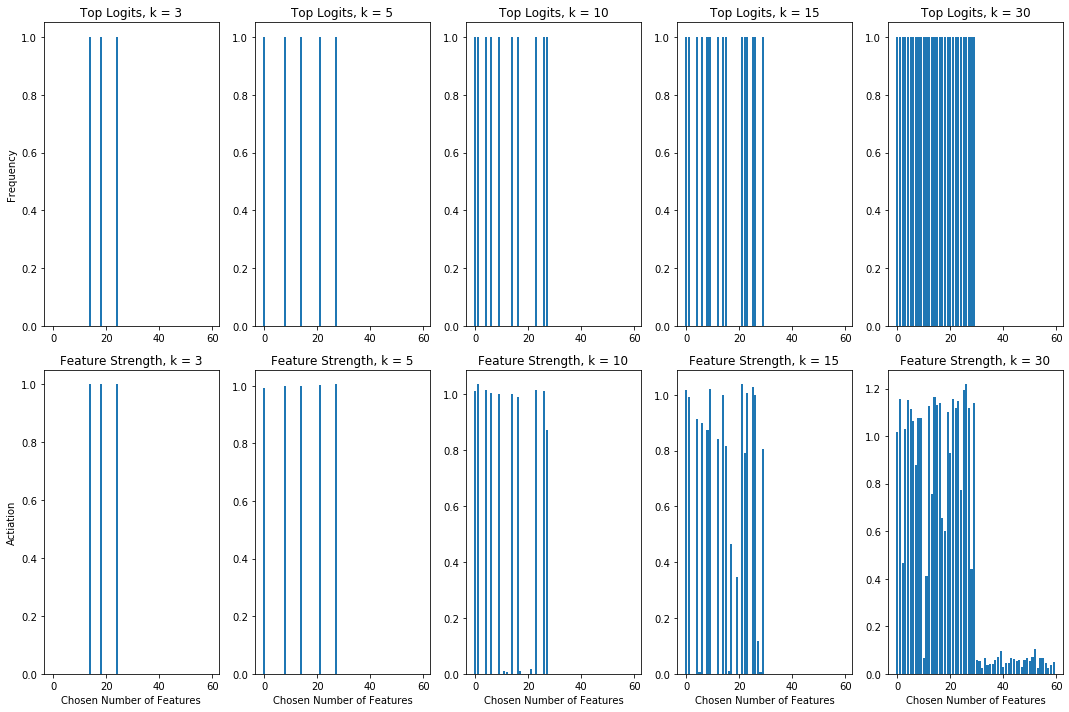

In [43]:
visualize_top_logits_generic(test_data, 'batching_gumbel_vae', 
                             VAE_Gumbel_NInsta, top_logits_gumbel_batching_vae_gumbel)

TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE


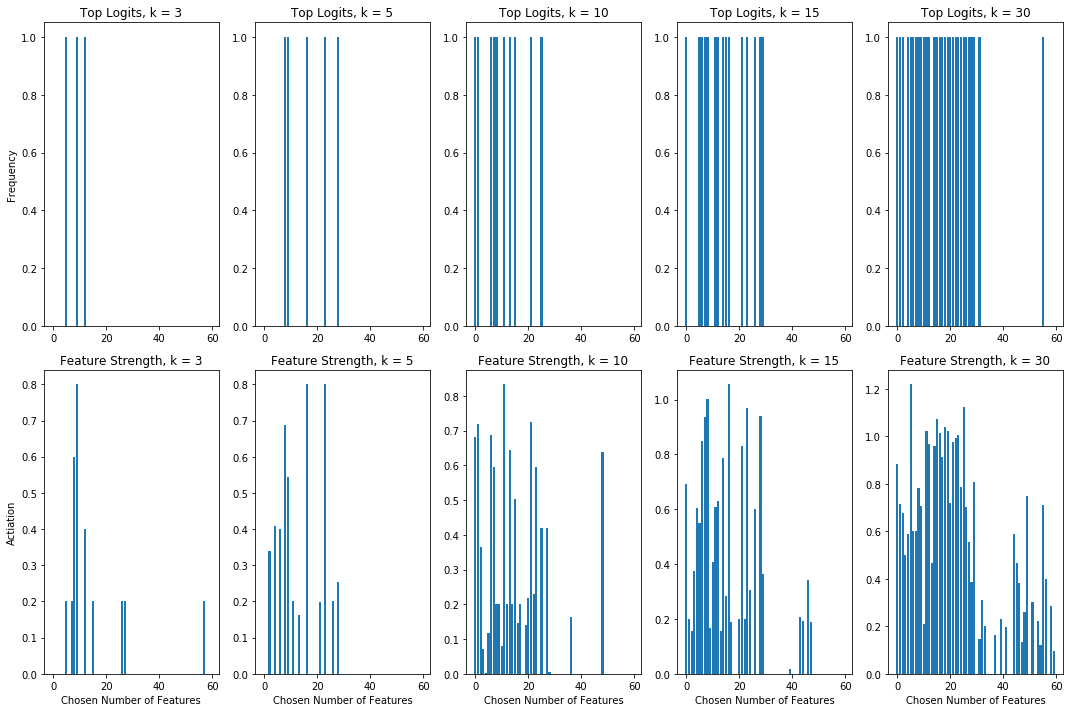

In [44]:
visualize_top_logits_generic(test_data, 'globalgate_vae', 
                             VAE_Gumbel_GlobalGate, top_logits_gumbel_globalgate_vae)

TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE


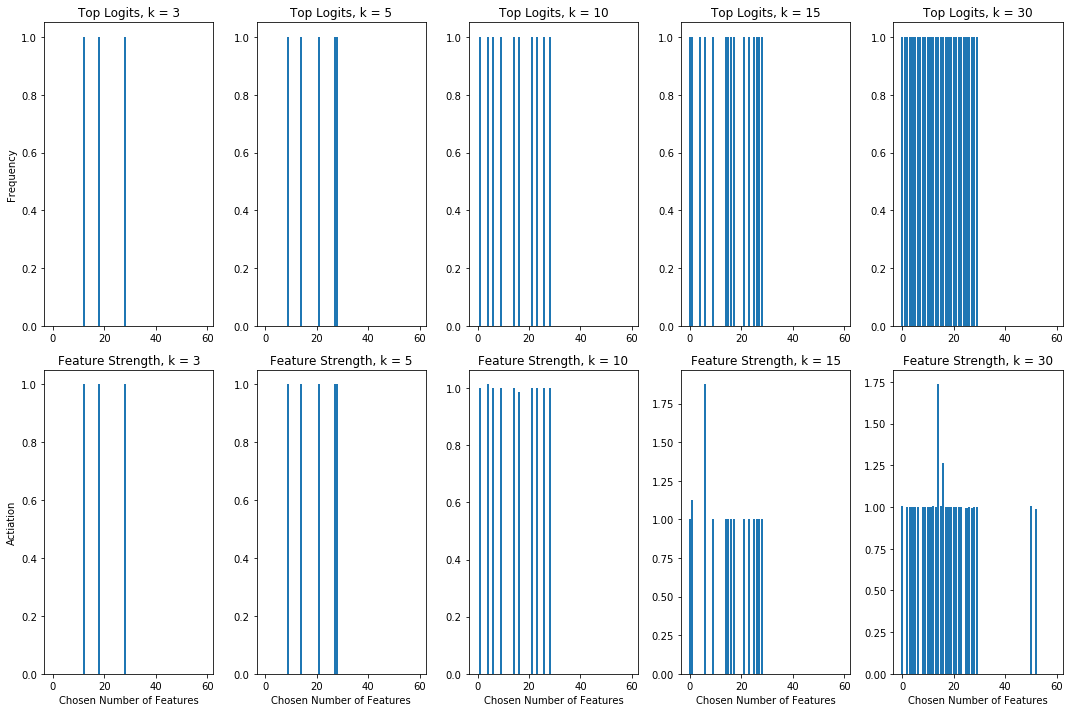

In [45]:
visualize_top_logits_generic(test_data, 'runningstate_vae', 
                             VAE_Gumbel_RunningState, top_logits_gumbel_runningstate_vae, trial_num=1)

TOP LOGITS ARE DE-DUPLICATED. MAKES CONCRETE LOOK WORSE


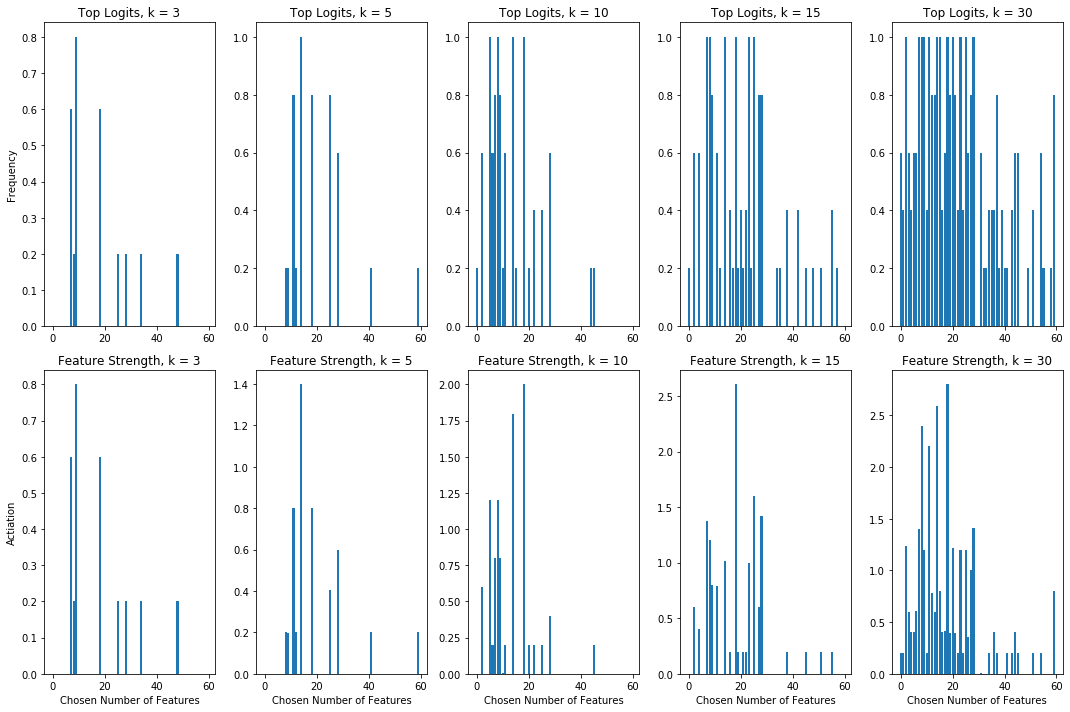

In [46]:
visualize_top_logits_generic(test_data, 'concrete_vae_nmsl', 
                             ConcreteVAE_NMSL, top_logits_gumbel_concrete_vae_nsml, trial_num=5)

Not as good as global gate or running state because it picks tings mulitple times.

Now Handle Distinct Rate

**Question**: How many in the top k are distinct?

In [163]:
def distinct_top_logits_vanilla_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    inds = np.arange(data.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(data)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]
            
            logits = model.weight_creator(batch_data)
            
            logits = logits.clone()

            logits = continuous_topk(logits, k=model.k, t=model.t, separate = True)

            max_idx = torch.argmax(logits, dim = 2, keepdim = True)
            one_hot = Tensor(logits.shape)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)

            # one_hot here is for each each instance, how many times did we pick a thing
            one_hot = one_hot.sum(dim = 0)
            
            one_hot[one_hot > 1] = 1
            all_logits += one_hot.sum(dim = 0)
    
    return all_logits.sum()/data.shape[0]/model.k

In [164]:
def distinct_top_logits_batching_vae_gumbel(data, model):
    assert isinstance(model, VAE_Gumbel_NInsta)
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    inds = np.arange(data.shape[0])
    num_batches = math.ceil(len(data)/batch_size)
    with torch.no_grad():
        for i in range(num_batches):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = data[batch_ind, :]

            w0 = model.weight_creator(batch_data)
            w = w0.mean(dim = 0)
            
            logits = continuous_topk(w, k=model.k, t=model.t, separate = True)

            max_idx = torch.argmax(logits, dim = 1, keepdim = True)
            one_hot = Tensor(logits.shape)
            one_hot.zero_()
            one_hot.scatter_(1, max_idx, 1)
            one_hot = one_hot.sum(dim = 0)
            one_hot[one_hot > 1] = 1
            all_logits += one_hot
            
    
        all_logits /= (num_batches * model.k)

    
    return all_logits.sum()

In [165]:
def distinct_top_logits_concrete_vae(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    all_logits = torch.zeros(data.shape[1], dtype = torch.float32)
    all_logits = all_logits.to(device)
    inds = np.arange(data.shape[0])
    num_batches = math.ceil(len(data)/batch_size)
    with torch.no_grad():
        
            
            
            
    
        all_logits /= (num_batches * model.k)

    
    return all_logits.sum()

In [166]:
# test model
path = '../data/models/final_run/vanilla_vae_gumbel/k_30/model_trial_3.pt'
model = VAE_Gumbel(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
distinct_top_logits_vanilla_vae_gumbel(test_data, model)

tensor(0.9162, device='cuda:0')

In [162]:
# test model
path = '../data/models/final_run/batching_gumbel_vae/k_30/model_trial_3.pt'
model = VAE_Gumbel_NInsta(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()

distinct_top_logits_batching_vae_gumbel(test_data, model).sum()


tensor(0.9135, device='cuda:0')

In [168]:
# test model
path = '../data/models/final_run/concrete_vae_nmsl/k_30/model_trial_3.pt'
model = ConcreteVAE_NMSL(2*D, 100, 20, k = 30, t = global_t) 
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()

ConcreteVAE_NMSL(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): Sigmoid()
  )
)

In [177]:
max_inds = torch.argmax(model.logit_enc, dim = 1)

In [181]:
one_hot = torch.nn.functional.one_hot(max_inds, num_classes = 2*D).sum(dim = 0)
one_hot[one_hot > 1] = 1 

In [183]:
1.0*one_hot.sum()/model.k

tensor(0.6000, device='cuda:0')